# setup

In [1]:
# https://nlp.stanford.edu/projects/glove/

In [2]:
from flask import Flask, request, jsonify
from flask_cors import CORS 
# import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
import nltk
import pymysql
import numpy as np
import datetime
app = Flask(__name__)
app.json.sort_keys = False
CORS(app) 

db = pymysql.connect(
    host='mysql5049.site4now.net',
    user='aa0682_movies',
    password='Password1234.',
    db='db_aa0682_movies',
    connect_timeout=8800,
    cursorclass=pymysql.cursors.DictCursor
)
sql_query= """
            SELECT 
                *
            FROM 
                article 
           """
db.ping(reconnect=True)
cursor = db.cursor()
cursor.execute(sql_query)
data = cursor.fetchall()


id = [row['article_id'] for row in data]
# overviews_orig = [row['abstract'] for row in data]
overviews = [row['abstract'] for row in data]
titles = [row['title'] for row in data] 
# titles_orig = [row['title']  for row in data] 
# author = [row['author']  for row in data] 
# keyword = [row['keyword']  for row in data] 
# date = [row['date']  for row in data] 


# Preprocessing
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

for n, name in enumerate(overviews):
    temp = name.lower().split(" ")
    temp = [''.join([letter for letter in word if letter.isalnum()]) for word in temp]
    temp = [word for word in temp if word not in stop_words]
    temp = ' '.join(temp)
    overviews[n] = temp
    
for n, title in enumerate(titles):
    temp = title.lower().split(" ")
    temp = [''.join([letter for letter in word if letter.isalnum()]) for word in temp]
    temp = [word for word in temp if word not in stop_words]
    temp = ' '.join(temp)
    titles[n] = temp
    
# Calculate cosine similarity
    from sklearn.feature_extraction.text import CountVectorizer

    vectorizer = CountVectorizer().fit(overviews + titles)
    # Calculate cosine similarity for overviews
    vectorizer_overviews = vectorizer.transform(overviews)
    cosine_sim_overviews = cosine_similarity(vectorizer_overviews)

    # Calculate cosine similarity for titles
    vectorizer_titles =  vectorizer.transform(titles)
    cosine_sim_titles = cosine_similarity(vectorizer_titles)
    
    article_id_to_index = {}  # Create an empty mapping
    for index, article_id in enumerate(id):
        article_id_to_index[article_id] = index

[nltk_data] Downloading package stopwords to C:\Users\My
[nltk_data]     Pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
journals = np.array([d['journal_id'] for d in data])
journal_name, counts = np.unique(journals, return_counts=True)
for i in range(len(counts)):
    print(journal_name[i], counts[i])

1 36
2 31
3 123


# LSTM Classifier

## Development stage

### preprocessing and training

In [4]:
import random
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import random
import os
from imblearn.over_sampling  import RandomOverSampler


In [88]:
EMBEDDING_DIM = 200
MAXLEN = 300
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
# MAX_EXAMPLES = 160000
TRAINING_SPLIT = 0.8

In [89]:

# # Your existing code to create the sentences_and_labels list
# # labels = [ '_'.join(sub['journal'].split(' ')) for n, sub in enumerate(data) ]
# labels = [sub['journal_id'] - 1 for sub in data]
# sentences_and_labels = list(zip(overviews, labels))

# # Create a dictionary to keep track of the count for each label
# label_count = {}

# # Filter the sentences_and_labels list to include only 30 instances for each label
# filtered_sentences_and_labels = []
# for sentence, label in sentences_and_labels:
#     if label not in label_count:
#         label_count[label] = 0

#     if label_count[label] < 30:
#         sentences_and_labels.append((sentence, label))
#         label_count[label] += 1

# # Perform random sampling on the filtered list
# random.seed(42)
# sentences_and_labels = random.sample(sentences_and_labels, len(overviews))

# # Unpack back into separate lists
# sentences, labels = zip(*sentences_and_labels)

# print(f"There are {len(sentences)} sentences and {len(labels)} labels\n")
# print(labels)



In [90]:
# Bundle the two lists into a single one
# labels = [ '_'.join(sub['journal'].split(' ')) for n,sub in enumerate(data) ]
labels = [sub['journal_id'] - 1 for sub in data]
for n,overview in enumerate(overviews):
    overviews[n] += overview + titles[n]
sentences_and_labels = list(zip(overviews, labels))

# # Perform random sampling
random.seed(42)
sentences_and_labels = random.sample(sentences_and_labels, len(overviews))

# Unpack back into separate lists
sentences, labels = zip(*sentences_and_labels)

print(f"There are {len(sentences)} sentences and {len(labels)} labels\n")

There are 190 sentences and 190 labels



In [91]:
def train_val_split(sentences, labels, training_split):
    """
    Splits the dataset into training and validation sets
    
    Args:
        sentences (list of string): lower-cased sentences without stopwords
        labels (list of string): list of labels
        training split (float): proportion of the dataset to convert to include in the train set
    
    Returns:
        train_sentences, validation_sentences, train_labels, validation_labels - lists containing the data splits
    """    
    ### START CODE HERE
    
    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(sentences)*training_split)

    ## Shuffle Lists
    temp = list(zip(sentences,labels))
    random.shuffle(temp)
    sentences,labels = zip(*temp)

    # Convert labels strings to integers
    # labels = label_encoder.fit_transform(labels)

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
    
    ### END CODE HERE
    
    return train_sentences, validation_sentences, train_labels, validation_labels

In [92]:
# Test your function
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 152 sentences for training.

There are 152 labels for training.

There are 38 sentences for validation.

There are 38 labels for validation.


In [93]:
print(np.unique(train_labels))
print(np.unique(val_labels))

[0 1 2]
[0 1 2]


In [94]:
def fit_tokenizer(train_sentences, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences
    
    Args:
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        oov_token (string) - symbol for the out-of-vocabulary token
    
    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """
    ### START CODE HERE
    
    # Instantiate the Tokenizer class, passing in the correct value for oov_token
    tokenizer = Tokenizer(oov_token=oov_token)
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)
    
    ### END CODE HERE
    
    return tokenizer

In [95]:
# Test your function
tokenizer = fit_tokenizer(train_sentences, OOV_TOKEN)

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary contains {VOCAB_SIZE} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")
print(f"\nindex of word 'gender' should be {word_index['gender']}")

Vocabulary contains 7015 words

<OOV> token included in vocabulary

index of word 'gender' should be 327


In [96]:
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):
    """
    Generates an array of token sequences and pads them to the same length
    
    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        truncating (string): type of truncating to use
        maxlen (int): maximum length of the token sequence
    
    Returns:
        pad_trunc_sequences (array of int): tokenized sentences padded to the same length
    """        
    ### START CODE HERE
       
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding, truncating and maxlen
    pad_trunc_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding, truncating=truncating)
    
    ### END CODE HERE
    
    return pad_trunc_sequences

In [97]:
# Test your function
train_pad_trunc_seq = seq_pad_and_trunc(train_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_and_trunc(val_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)

print(f"Padded and truncated training sequences have shape: {train_pad_trunc_seq.shape}\n")
print(f"Padded and truncated validation sequences have shape: {val_pad_trunc_seq.shape}")

Padded and truncated training sequences have shape: (152, 300)

Padded and truncated validation sequences have shape: (38, 300)


In [98]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

In [99]:
val_labels

array([0, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2,
       1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 0, 2, 0, 1, 1])

In [100]:
# Define path to file containing the embeddings
GLOVE_FILE = './glove.6B.200d.txt'

# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS = {}

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE, encoding="utf8", errors="ignore") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

In [101]:
test_word = 'gender'

test_vector = GLOVE_EMBEDDINGS[test_word]

print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")

Vector representation of word gender looks like this:

[ 0.31414   0.039937  0.18007  -0.10655   0.41687  -0.10857  -0.69551
 -0.024218 -0.51403  -0.034071  0.14223   0.98964   0.055305 -0.49348
 -0.29643   0.22581  -0.18745  -0.48138   0.59107   0.1408    1.041
  2.0157    0.059323  0.36618   0.5409    0.077235  0.94134  -1.0835
 -0.15501   0.16847   0.11451  -0.81755  -0.087729  0.03114  -0.27427
 -0.037571  0.17335  -0.52963   0.083644 -0.099551  0.11298  -0.39948
 -0.016848  0.24857  -0.79707   0.080887 -0.25887  -0.37116   0.35246
 -0.55675   0.074563  0.62295   0.13652   0.88841   0.028324  0.72354
  0.23913   0.10532   0.53442  -0.067557 -0.76906   0.58212  -0.20706
  1.1397    0.11476   0.78226   0.20242   1.1421    0.80678   0.49675
  0.58517   0.74437   0.16848   0.23775  -0.24336  -0.39133  -0.25031
  0.024153  0.37198  -0.21762  -0.39776  -0.28984  -0.4485    0.48314
  0.57934  -0.23749  -0.54987  -0.22377   0.86898  -0.36287   0.39069
 -0.69271   0.32923   0.32524   0.4854

In [102]:
# Initialize an empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for 
# each word exists within GloVe's representations, save it in the EMBEDDINGS_MATRIX array
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

In [103]:
# GRADED FUNCTION: create_model
def create_model(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    """
    Creates a binary sentiment classifier model
    
    Args:
        vocab_size (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
        embeddings_matrix (array): predefined weights of the embeddings
    
    Returns:
        model (tf.keras Model): the sentiment classifier model
    """
    ### START CODE HERE
    
    model = tf.keras.Sequential([ 
        # This is how you need to set the Embedding layer when using pre-trained embeddings
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, batch_input_shape=(None, maxlen), weights=[embeddings_matrix], trainable=False), 
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation="tanh", return_sequences=True)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation="tanh")),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=optimizers.Adam(1e-5),
                  metrics=['accuracy']) 

    ### END CODE HERE

    return model

In [104]:
# Create your untrained model
model = create_model(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 200)          1403200   
                                                                 
 bidirectional_4 (Bidirectio  (None, 300, 256)         336896    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 300, 256)          0         
                                                                 
 batch_normalization_2 (Batc  (None, 300, 256)         1024      
 hNormalization)                                                 
                                                                 
 bidirectional_5 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                      

In [105]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=1e-7)
es = EarlyStopping(monitor='val_loss', patience=10, mode="min", restore_best_weights=True)

In [106]:
# Train the model and save the training history
history = model.fit(train_pad_trunc_seq, train_labels, epochs=256, 
                    validation_data=(val_pad_trunc_seq, val_labels), 
                    callbacks=[reduce_lr, es],
                    batch_size=8)

Epoch 1/256


19/19 [==============================] - 6s 124ms/step - loss: 1.0628 - accuracy: 0.4474 - val_loss: 1.0853 - val_accuracy: 0.4211 - lr: 1.0000e-05
Epoch 2/256
19/19 [==============================] - 1s 72ms/step - loss: 1.0367 - accuracy: 0.5000 - val_loss: 1.0836 - val_accuracy: 0.4211 - lr: 1.0000e-05
Epoch 3/256
19/19 [==============================] - 1s 72ms/step - loss: 1.0524 - accuracy: 0.4737 - val_loss: 1.0804 - val_accuracy: 0.5526 - lr: 1.0000e-05
Epoch 4/256
19/19 [==============================] - 1s 71ms/step - loss: 1.0281 - accuracy: 0.5789 - val_loss: 1.0759 - val_accuracy: 0.6842 - lr: 1.0000e-05
Epoch 5/256
19/19 [==============================] - 1s 74ms/step - loss: 1.0366 - accuracy: 0.5066 - val_loss: 1.0697 - val_accuracy: 0.7105 - lr: 1.0000e-05
Epoch 6/256
19/19 [==============================] - 1s 74ms/step - loss: 1.0110 - accuracy: 0.5658 - val_loss: 1.0628 - val_accuracy: 0.7368 - lr: 1.0000e-05
Epoch 7/256
19/19 [==============================] - 1s 7

In [107]:
## Testing
number = 150
test_data = train_pad_trunc_seq[number].reshape(1,MAXLEN)
ground_truth = train_labels[number]
classification = model.predict(test_data)

print('Ground Truth:', ground_truth)
print('Classification Truth:', np.argmax((classification)) )

print('Actual Input Sentence', )


1/1 [==============================] - 1s 884ms/step
Ground Truth: 0
Classification Truth: 0
Actual Input Sentence


In [108]:
## Best model saved
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

best_epoch = np.argmin(np.array(val_loss))

print("Best Epoch: ", best_epoch)
print("Final Train Loss: {:.4f}".format(train_loss[best_epoch]))
print("Final Validation Loss: {:.4f}".format(val_loss[best_epoch]))
print("Final Train accuracy: {:.2f}".format(train_accuracy[best_epoch]*100))
print("Final Test accuracy: {:.2f}".format(val_accuracy[best_epoch]*100))

Best Epoch:  91
Final Train Loss: 0.4996
Final Validation Loss: 0.6588
Final Train accuracy: 78.95
Final Test accuracy: 73.68


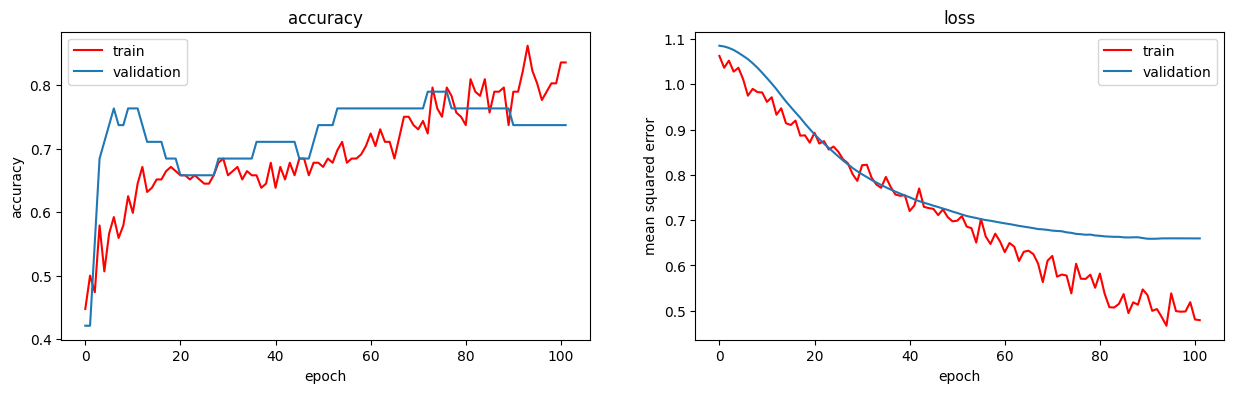

In [109]:
## Graphing Result of training
plt.figure(figsize=(15,4))

plt.subplot(121)
plt.plot(history.history['accuracy'], color ='r')
plt.plot(history.history['val_accuracy'])
plt.title('accuracy')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.subplot(122)
plt.plot(history.history['loss'], color ='r')
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('mean squared error')

# displaying the figure
plt.show()

### saving

In [110]:
## General save path
import os
version = len(os.listdir('models'))+2
save_path = 'models/classifier_v{:d}/'.format(version)
os.mkdir(save_path)

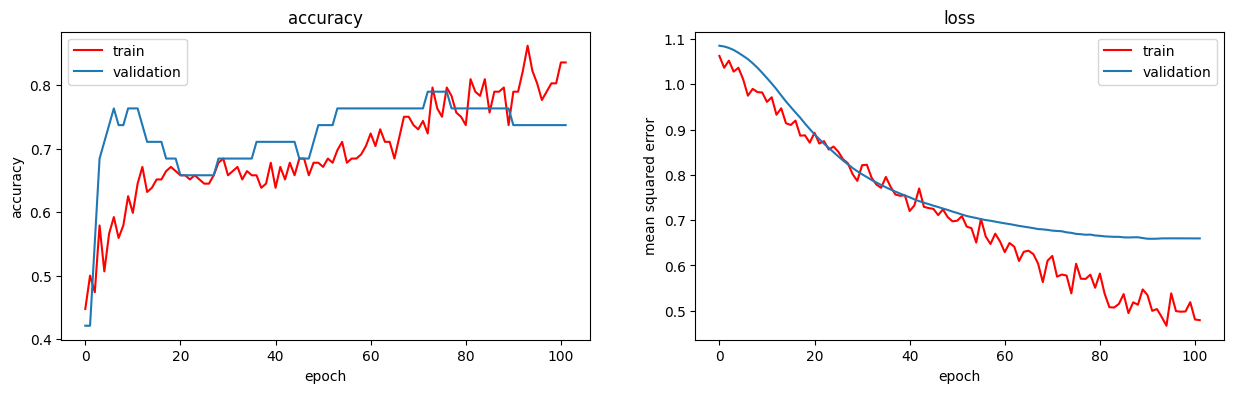

In [111]:
# Saving the figure.
## Graphing Result of training
plt.figure(figsize=(15,4))

plt.subplot(121)
plt.plot(history.history['accuracy'], color ='r')
plt.plot(history.history['val_accuracy'])
plt.title('accuracy')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.subplot(122)
plt.plot(history.history['loss'], color ='r')
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('mean squared error')

plt.savefig(save_path+"output.jpg")

In [112]:
## Save best metrics
with open(save_path+'metrics.txt', 'w') as f:
    f.write("Best Epoch: {:d} \n".format(best_epoch))
    f.write("Final Train Loss: {:.4f}\n".format(train_loss[best_epoch]))
    f.write("Final Validation Loss: {:.4f}\n".format(val_loss[best_epoch]))
    f.write("Final Train accuracy: {:.2f}%\n".format(train_accuracy[best_epoch]*100))
    f.write("Final Test accuracy: {:.2f}%\n".format(val_accuracy[best_epoch]*100))

In [113]:
## save number of words used
with open(save_path+'readme.txt','w') as f:
    f.write('This classifier model only uses the first {:d} words of the abstract.'.format(MAXLEN))

In [114]:
## saving model
model.save(save_path+'model.h5')

In [115]:
## saving tokenizer and label_encoder
import pickle

# saving
with open(save_path+'tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(save_path+'label_encoder.pickle', 'wb') as handle:
#     pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Functions to Export

In [116]:
import numpy as np
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

In [117]:
def load_tokenizer(path):
    '''
        load tokenizer for abstract processing
    '''

    with open(path, 'rb') as handle:
        tokenizer = pickle.load(handle)
        
    return tokenizer

# def load_label_encoder(path):
#     '''
#         loading label encoder for journal name processing
#     '''

#     with open(path, 'rb') as handle:
#         label_encoder = pickle.load(handle)

#     return label_encoder

In [118]:
def preprocess_abstract(abstract, tokenizer, label=None):
    '''
        Function to preprocess abstract before classification 

        arguments:
            abstract = raw abstract in string
            tokenizer = tokenizer used by model for training
            label = label of abstrat (for testing purposes only)

        The output is an array of integer ID for each word with the same length of 250.
        the words are arranged by order or apperance. only first words are retained. 

        if words is less than 250, the remaining spaces will be filled with zeros
        if words is greater than 250, the excess words will be ignored
    '''
    
    ## Text Preprocessing
    abstract = abstract.lower().split(" ")
    abstract = [''.join([letter for letter in word if letter.isalnum()]) for word in abstract]
    abstract = [word for word in abstract if word not in stop_words]
    abstract = ' '.join(abstract)
    
    ## Assign unique ID to each word in abstract
    sequences = tokenizer.texts_to_sequences([abstract])

    ## Fill with zeros or Truncate array of word IDs. Max length is 250.
    pad_trunc_sequences = pad_sequences(sequences, maxlen=300, padding='post', truncating='post')

    return pad_trunc_sequences, label

In [119]:
def classify(input_data, model):
    '''
        Function to classify processed abstract 
        arguments: 
            input_data = processed abstract
            model = A.I. model
            label_encoder = label_encoder used by model for training

        the output of the function is the journal name
    '''

    ## classify abstract using model
    output = model(input_data)

    ## Get the highest probability of classification
    output = np.argmax(output)

    ## Get the journal name equivalent of the output of classification
    journal = output + 1

    ## replace _ with whitespace in the journal name
    # journal = ' '.join(journal[0].split('_'))
    
    return journal

In [120]:
## Load tokenizer and encoder
tokenizer = load_tokenizer(save_path+'//tokenizer.pickle')
# label_encoder = load_label_encoder(save_path+'//label_encoder.pickle')

## load model
model = load_model(save_path+'//model.h5')

## Preprocess abstract
input_data, input_label = preprocess_abstract(data[34]['abstract'],tokenizer, label = data[34]['journal_id'])

## classify abstract
result = classify(input_data, model)

## results
print('Ground Truth:',input_label)
print('Classification Output:',result)

Ground Truth: 3
Classification Output: 2


# SVM Classifier

In [121]:
# import pandas as pd
# import numpy as np
# from nltk.tokenize import word_tokenize
# from nltk import pos_tag
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# from sklearn.preprocessing import LabelEncoder
# from collections import defaultdict
# from nltk.corpus import wordnet as wn
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn import model_selection, naive_bayes, svm
# from sklearn.metrics import accuracy_score
# import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

In [122]:
# import random
# # Bundle the two lists into a single one
# labels = [ '_'.join(sub['journal'].split(' ')) for n,sub in enumerate(data) ]
# sentences_and_labels = list(zip(overviews, labels))

# # # Perform random sampling
# # random.seed(42)
# sentences_and_labels = random.sample(sentences_and_labels, len(overviews))

# # Unpack back into separate lists
# sentences, labels = zip(*sentences_and_labels)

# print(f"There are {len(sentences)} sentences and {len(labels)} labels\n")
# Corpus = overviews

In [123]:
# # Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
# Corpus = [entry.lower() for entry in Corpus]
# # Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
# Corpus= [word_tokenize(entry) for entry in Corpus]
# # Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# # WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
# tag_map = defaultdict(lambda : wn.NOUN)
# tag_map['J'] = wn.ADJ
# tag_map['V'] = wn.VERB
# tag_map['R'] = wn.ADV
# for index,entry in enumerate(Corpus):
#     # Declaring Empty List to store the words that follow the rules for this step
#     Final_words = []
#     # Initializing WordNetLemmatizer()
#     word_Lemmatized = WordNetLemmatizer()
#     # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
#     for word, tag in pos_tag(entry):
#         # Below condition is to check for Stop words and consider only alphabets
#         if word not in stopwords.words('english') and word.isalpha():
#             word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
#             Final_words.append(word_Final)
#     # The final processed set of words for each iteration will be stored in 'text_final'
#     Corpus[index] = str(Final_words)

In [124]:
# Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus,labels,test_size=0.2)

In [125]:
# Encoder = LabelEncoder()
# Train_Y = Encoder.fit_transform(Train_Y)
# Test_Y = Encoder.fit_transform(Test_Y)

In [126]:
# Tfidf_vect = TfidfVectorizer(max_features=1000)
# Tfidf_vect.fit(Corpus)
# Train_X_Tfidf = Tfidf_vect.transform(Train_X)
# Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [127]:
# print(Tfidf_vect.vocabulary_)

In [128]:
# # Classifier - Algorithm - SVM
# # fit the training dataset on the classifier
# SVM = svm.SVC(C=2, kernel='rbf', degree=3)
# SVM.fit(Train_X_Tfidf,Train_Y)
# # predict the labels on validation dataset
# predictions_SVM = SVM.predict(Test_X_Tfidf)
# # Use accuracy_score function to get the accuracy
# print("SVM Train Accuracy  Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)
# print("SVM Test Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)